#### Import libraries

In [1]:
# Add the parent directory to the path to import from src
import sys
sys.path.append('..')

# Import other libraries

import numpy as np
import pandas as pd
import importlib

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_classification
from sklearn.preprocessing import StandardScaler


from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, precision_recall_curve, average_precision_score

#### Generate Data

In [29]:

# Set random seed for reproducibility
np.random.seed(42)

n_samples = 100000
n_features = 10
n_classes = 2

# Generate synthetic classification dataset
X, y = make_classification(
    n_samples=n_samples,          # N observations
    n_features=n_features,        # M feature columns
    n_informative=n_features//2,  # Number of informative features
    n_redundant=n_features//3,    # Number of redundant features
    n_classes=n_classes,          # classification labels
    n_clusters_per_class=3,       # Number of clusters per class
    weights=[0.66, 0.33],         # Class balance (60% class 0, 40% class 1)
    flip_y=0.03,                  # Add 3% label noise
    class_sep=0.8,                # Separation between classes
    hypercube=True,               # Features uniformly distributed on hypercube
    shift=0.0,                    # Shift features by this value
    scale=1.0,                    # Multiply features by this value
    shuffle=True,                 # Shuffle samples and features
    random_state=42               # Random state for reproducibility
)

# Create a DataFrame with the features and target
column_names = [f'feature_{i+1}' for i in range(10)]
df = pd.DataFrame(X, columns=column_names)
df['y_label'] = y

##### Display basic information about the dataset

In [30]:

print("Dataset Shape:", df.shape)
print("\nFirst 5 rows:")
print(df.head())

print("\nDataset Info:")
print(df.info())

print("\nClass Distribution:")
print(df['y_label'].value_counts())
print(f"\nClass Balance: {df['y_label'].value_counts(normalize=True).round(3).to_dict()}")

Dataset Shape: (100000, 11)

First 5 rows:
   feature_1  feature_2  feature_3  feature_4  feature_5  feature_6  \
0   0.219130  -1.215372  -1.859913   1.877458  -0.449327  -1.501699   
1   0.895510  -0.234500  -0.150715  -0.600025   0.104029  -0.987077   
2  -0.278681  -0.118109  -0.700434   0.673730  -0.560444  -0.458627   
3   0.577220   0.123543   0.623718  -0.419219  -0.148984  -0.784166   
4  -0.135901   2.447609   0.867625   0.284431  -2.149382   3.519820   

   feature_7  feature_8  feature_9  feature_10  y_label  
0  -2.289312  -0.070954   0.233698   -0.348957        1  
1   0.352600   1.064372   1.225859   -0.410703        1  
2  -1.282462  -1.057117  -0.989605   -0.460219        0  
3   0.099965   0.253403   1.427870   -1.608221        1  
4   0.681196  -1.076521  -2.108098    2.607774        1  

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 11 columns):
 #   Column      Non-Null Count   Dtype  
---  ------    

##### Statistical summary of features

In [31]:
df.describe().round(3)

,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,y_label
count,100000.000,100000.000,100000.000,100000.000,100000.000,100000.000,100000.000,100000.000,100000.000,100000.000,100000.000
mean,0.092,-0.579,-0.619,0.001,0.620,-0.913,0.000,0.372,-0.267,0.092,0.340
std,1.489,1.415,1.249,0.999,1.282,1.994,1.002,1.543,1.388,1.775,0.474
min,-7.617,-8.392,-6.017,-4.283,-5.394,-11.432,-4.319,-6.147,-7.355,-7.610,0.000
25%,-0.864,-1.432,-1.469,-0.673,-0.219,-2.193,-0.678,-0.714,-1.215,-1.108,0.000
50%,0.306,-0.493,-0.628,0.004,0.647,-0.984,0.003,0.093,-0.166,0.083,0.000
75%,1.043,0.322,0.247,0.678,1.489,0.293,0.676,1.204,0.748,1.302,1.000
max,6.157,5.767,4.972,4.527,5.853,11.457,4.679,9.893,5.421,8.302,1.000


##### Visualize feature distributions

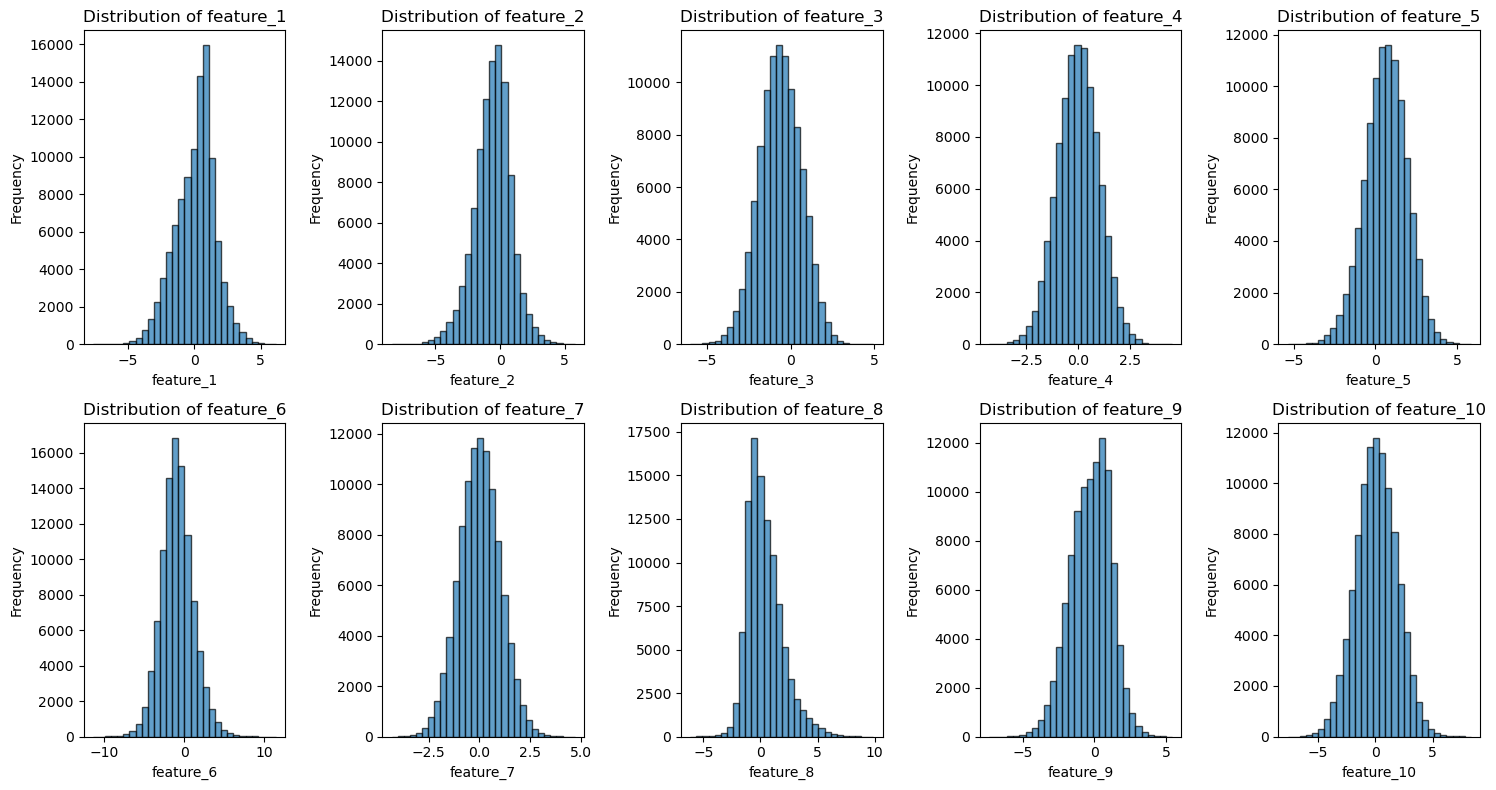

In [32]:
fig, axes = plt.subplots(2, 5, figsize=(15, 8))
axes = axes.ravel()

for i, col in enumerate(column_names):
    axes[i].hist(df[col], bins=30, alpha=0.7, edgecolor='black')
    axes[i].set_title(f'Distribution of {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

##### Box plots by class

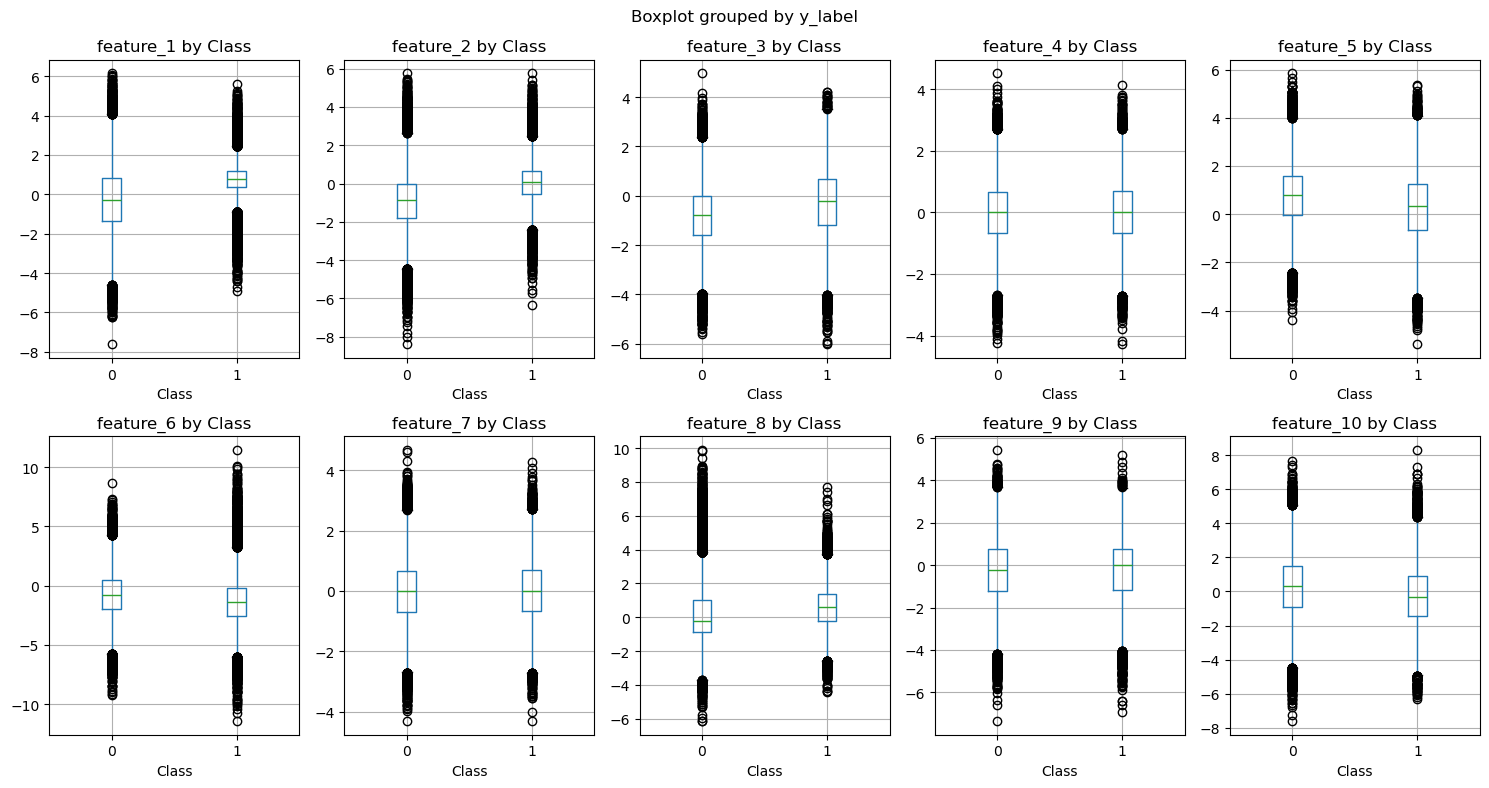

In [33]:

fig, axes = plt.subplots(2, 5, figsize=(15, 8))
axes = axes.ravel()

for i, col in enumerate(column_names):
    df.boxplot(column=col, by='y_label', ax=axes[i])
    axes[i].set_title(f'{col} by Class')
    axes[i].set_xlabel('Class')

plt.tight_layout()


##### Feature correlation matrix

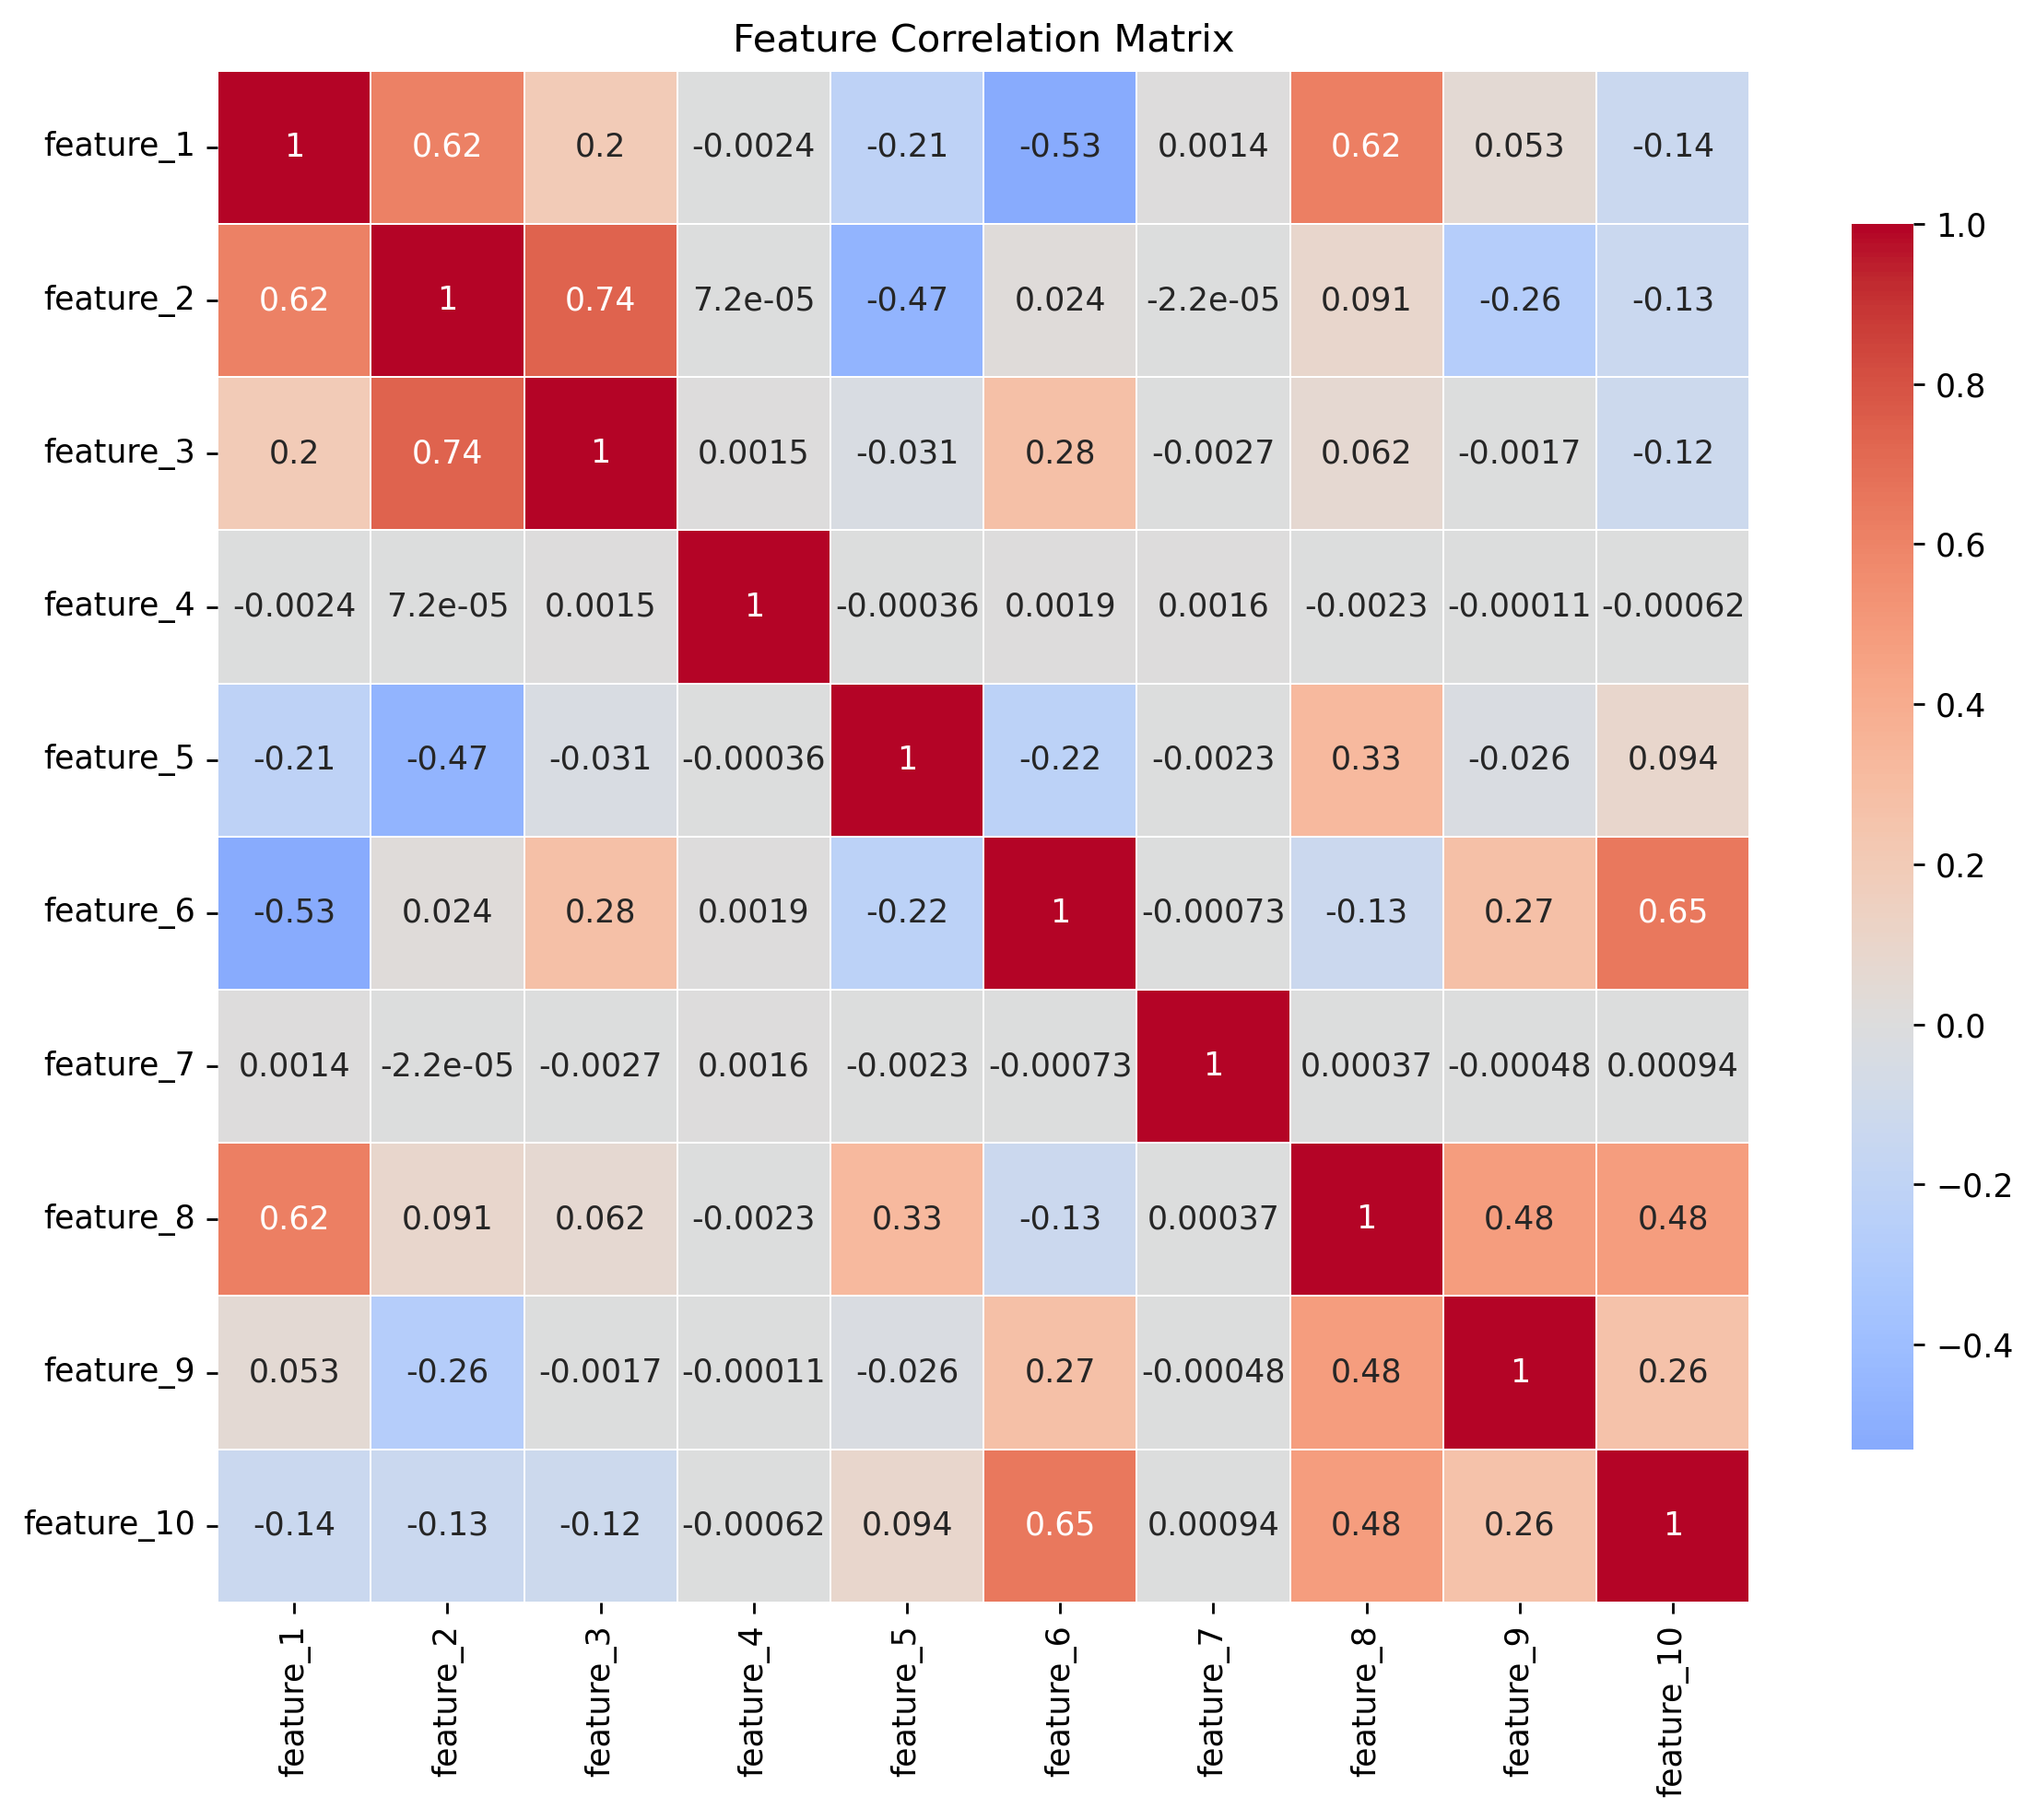

In [34]:
plt.figure(figsize=(10, 8), dpi=250)
correlation_matrix = df[column_names].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
            square=True, linewidths=0.5, cbar_kws={"shrink": 0.8})
plt.title('Feature Correlation Matrix')
plt.tight_layout()

#### Data Preparation for training

In [36]:
# Separate features and target

X = df[column_names].values
y = df['y_label'].values

# Split into train and test sets (80-20 split)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Scale the features (important for neural networks)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Training set shape:", X_train_scaled.shape)
print("Test set shape:", X_test_scaled.shape)
print("\nTraining set class distribution:")
print(pd.Series(y_train).value_counts())
print("\nTest set class distribution:")
print(pd.Series(y_test).value_counts())


Training set shape: (80000, 10)
Test set shape: (20000, 10)

Training set class distribution:
0    52780
1    27220
Name: count, dtype: int64

Test set class distribution:
0    13195
1     6805
Name: count, dtype: int64


In [7]:
# Save the dataset to files (optional)
data_path = "../data"

# Save as CSV
df.to_csv(f'{data_path}/synthetic_classification_dataset.csv', index=False)
print(f"Dataset saved to '{data_path}/synthetic_classification_dataset.csv'")

# Save preprocessed numpy arrays for direct use in deep learning
np.savez(f'{data_path}/synthetic_classification_arrays.npz',
         X_train=X_train_scaled,
         X_test=X_test_scaled,
         y_train=y_train,
         y_test=y_test)
print(f"Preprocessed arrays saved to '{data_path}/synthetic_classification_arrays.npz'")

Dataset saved to '../data/synthetic_classification_dataset.csv'
Preprocessed arrays saved to '../data/synthetic_classification_arrays.npz'


### Model training

#### Baseline Models

##### XGBoost Baseline


In [ ]:
# Import the XGBoost baseline model
# First, reload the module to ensure we have the latest version
import importlib
import src.models_baseline
importlib.reload(src.models_baseline)

# Now import the function
from src.models_baseline import build_xgboost

In [ ]:
# Build an XGBoost model for our dataset
# num_classes=2 for binary classification
xgb_model = build_xgboost(
    num_classes=2,
    n_estimators=100,
    max_depth=6,
    learning_rate=0.3,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

print("XGBoost model created successfully!")
print(f"Model type: {type(xgb_model)}")
print(f"Model parameters: {xgb_model.get_params()}")


XGBoost model created successfully!
Model type: <class 'xgboost.sklearn.XGBClassifier'>
Model parameters: {'objective': 'binary:logistic', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': 0.8, 'device': None, 'early_stopping_rounds': 10, 'enable_categorical': True, 'eval_metric': None, 'feature_types': None, 'feature_weights': None, 'gamma': None, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': 0.3, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': 6, 'max_leaves': None, 'min_child_weight': 1, 'missing': nan, 'monotone_constraints': None, 'multi_strategy': None, 'n_estimators': 100, 'n_jobs': None, 'num_parallel_tree': None, 'random_state': 42, 'reg_alpha': 0, 'reg_lambda': 1, 'sampling_method': None, 'scale_pos_weight': None, 'subsample': 0.8, 'tree_method': 'hist', 'validate_parameters': None, 'verbos

In [ ]:
# Train the XGBoost model
# Note: XGBoost doesn't require scaled features, but we can use them
# For consistency, we'll use the unscaled features (X_train, X_test)

# Train the model
print("Training XGBoost model...")
xgb_model.fit(
    X_train, 
    y_train,
    eval_set=[(X_test, y_test)],  # Monitor performance on test set
    verbose=True
)

print(f"\nBest iteration: {xgb_model.best_iteration}")
print(f"Best score: {xgb_model.best_score}")

Training XGBoost model...
[0]	validation_0-logloss:0.55374
[1]	validation_0-logloss:0.48010
[2]	validation_0-logloss:0.42963
[3]	validation_0-logloss:0.39609
[4]	validation_0-logloss:0.37085
[5]	validation_0-logloss:0.35309
[6]	validation_0-logloss:0.32715
[7]	validation_0-logloss:0.31358
[8]	validation_0-logloss:0.30074
[9]	validation_0-logloss:0.28868
[10]	validation_0-logloss:0.28382
[11]	validation_0-logloss:0.27918
[12]	validation_0-logloss:0.26720
[13]	validation_0-logloss:0.26172
[14]	validation_0-logloss:0.25637
[15]	validation_0-logloss:0.24676
[16]	validation_0-logloss:0.24349
[17]	validation_0-logloss:0.24073
[18]	validation_0-logloss:0.23652
[19]	validation_0-logloss:0.23201
[20]	validation_0-logloss:0.22973
[21]	validation_0-logloss:0.22700
[22]	validation_0-logloss:0.22586
[23]	validation_0-logloss:0.22538
[24]	validation_0-logloss:0.22421
[25]	validation_0-logloss:0.22316
[26]	validation_0-logloss:0.22243
[27]	validation_0-logloss:0.22151
[28]	validation_0-logloss:0.2209

/Users/nilesh-patil/Documents/projects/Github/papers/paper-tabm/.pixi/envs/default/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [14:17:45] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1748292887431/work/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()


[58]	validation_0-logloss:0.19771
[59]	validation_0-logloss:0.19765
[60]	validation_0-logloss:0.19759
[61]	validation_0-logloss:0.19741
[62]	validation_0-logloss:0.19746
[63]	validation_0-logloss:0.19738
[64]	validation_0-logloss:0.19737
[65]	validation_0-logloss:0.19608
[66]	validation_0-logloss:0.19606
[67]	validation_0-logloss:0.19450
[68]	validation_0-logloss:0.19333
[69]	validation_0-logloss:0.19278
[70]	validation_0-logloss:0.19266
[71]	validation_0-logloss:0.19278
[72]	validation_0-logloss:0.19260
[73]	validation_0-logloss:0.19221
[74]	validation_0-logloss:0.19200
[75]	validation_0-logloss:0.19152
[76]	validation_0-logloss:0.19129
[77]	validation_0-logloss:0.19082
[78]	validation_0-logloss:0.19063
[79]	validation_0-logloss:0.19071
[80]	validation_0-logloss:0.19069
[81]	validation_0-logloss:0.19048
[82]	validation_0-logloss:0.19040
[83]	validation_0-logloss:0.19042
[84]	validation_0-logloss:0.19007
[85]	validation_0-logloss:0.19019
[86]	validation_0-logloss:0.19029
[87]	validatio

##### DL Baseline

In [8]:
# Import the baseline model
from src.models_baseline import build_mlp

# Build a model for our dataset
# Input shape is (10,) since we have 10 features
# num_classes is 1 for binary classification with sigmoid activation
model_mlp = build_mlp(
    input_shape=(10,),
    num_classes=1,  # Binary classification
    num_layers=4,
    hidden_units=256,
    dropout_rate=0.2
)

# Display model summary
model_mlp.summary()

/Users/nilesh-patil/Documents/projects/Github/papers/paper-tabm/.pixi/envs/default/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 256)            │         2,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 200,449 (783.00 KB)

 Trainable params: 200,449 (783.00 KB)

 Non-trainable params: 0 (0.00 B)

In [10]:
# Compile the model
model_mlp.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy', 'AUC']
)

# Create a validation split from training data
from sklearn.model_selection import train_test_split

X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X_train_scaled, 
    y_train, 
    test_size=0.2, 
    random_state=42, 
    stratify=y_train
)

print(f"Training split shape: {X_train_split.shape}")
print(f"Validation split shape: {X_val_split.shape}")

# Example: Train the model (you can uncomment to run)

history = model_mlp.fit(
    X_train_split, y_train_split,
    validation_data=(X_val_split, y_val_split),
    epochs=50,
    batch_size=128,
    verbose=1
)


Training split shape: (64000, 10)
Validation split shape: (16000, 10)
Epoch 1/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.9225 - accuracy: 0.8665 - loss: 0.3245 - val_AUC: 0.9740 - val_accuracy: 0.9424 - val_loss: 0.1856
Epoch 2/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.9754 - accuracy: 0.9411 - loss: 0.1819 - val_AUC: 0.9772 - val_accuracy: 0.9532 - val_loss: 0.1554
Epoch 3/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.9767 - accuracy: 0.9492 - loss: 0.1629 - val_AUC: 0.9790 - val_accuracy: 0.9574 - val_loss: 0.1434
Epoch 4/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.9791 - accuracy: 0.9531 - loss: 0.1515 - val_AUC: 0.9789 - val_accuracy: 0.9617 - val_loss: 0.1358
Epoch 5/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.9794 - accuracy: 0.9556 - loss: 0.1474 - val_AUC: 0.9783 - val_accuracy: 0.9588 - val_loss: 0.1399
Epoch 6/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.9803 - accuracy: 0.9578 - loss: 0.1405 - val_AUC: 0.9792 - val_accura

In [11]:
# Example: Making predictions with the model
# Note: This uses the untrained model - in practice, train first!

# Make predictions on test data
predictions_proba = model_mlp.predict(X_test_scaled[:10])  # First 10 samples
predictions_class = (predictions_proba > 0.5).astype(int)

# Display predictions
results_df = pd.DataFrame({
    'True_Label': y_test[:10],
    'Predicted_Probability': predictions_proba.flatten(),
    'Predicted_Class': predictions_class.flatten()
})

# Example: Evaluation metrics (after training)
from sklearn.metrics import classification_report, confusion_matrix

# After training the model:
y_pred = (model_mlp.predict(X_test_scaled) > 0.5).astype(int)
print(classification_report(y_test, y_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 455us/step
              precision    recall  f1-score   support

           0       0.97      0.97      0.97     11936
           1       0.96      0.95      0.95      8064

    accuracy                           0.96     20000
   macro avg       0.96      0.96      0.96     20000
weighted avg       0.96      0.96      0.96     20000


Confusion Matrix:
[[11599   337]
 [  400  7664]]


#### TabM Models

##### TabM - Naive

In [91]:
# Import TabM models
from src.models_tabm import build_tabm
importlib.reload(src.models_tabm)

# Build TabM naive model
input_shape = X_train_scaled.shape[1:]  # Shape of individual samples
num_classes = 1  # Binary classification
k = 32  # Number of ensemble members
num_layers = 4
hidden_units = 256
dropout_rate = 0.2

tabm_naive = build_tabm(
    variant='naive',
    input_shape=input_shape,
    num_classes=num_classes,
    k=k,
    num_layers=num_layers,
    hidden_units=hidden_units,
    dropout_rate=dropout_rate
)

# Compile the model
tabm_naive.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Display model summary
print("TabM Naive Model Architecture:")
print("=" * 50)
tabm_naive.summary()

# Prepare data for TabM (replicate input k times)
X_train_tabm = np.tile(X_train_scaled[:, np.newaxis, :], (1, k, 1))
X_test_tabm = np.tile(X_test_scaled[:, np.newaxis, :], (1, k, 1))

# Train TabM naive model
print("\nTraining TabM Naive Model...")
print("=" * 50)

tabm_naive_history = tabm_naive.fit(
    X_train_tabm, y_train,
    validation_data=(X_test_tabm, y_test),
    epochs=25,
    batch_size=32,
    verbose=1
)

# Evaluate TabM naive model
tabm_naive_pred_proba = tabm_naive.predict(X_test_tabm).flatten()
tabm_naive_pred_class = (tabm_naive_pred_proba > 0.5).astype(int)

tabm_naive_accuracy = accuracy_score(y_test, tabm_naive_pred_class)
tabm_naive_auc = roc_auc_score(y_test, tabm_naive_pred_proba)

print("\nTabM Naive Model Performance")
print("=" * 50)
print(f"Accuracy: {tabm_naive_accuracy:.4f}")
print(f"AUC-ROC: {tabm_naive_auc:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, tabm_naive_pred_class))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, tabm_naive_pred_class))

TabM Naive Model Architecture:


Model: "functional_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 32, 10)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_ensemble_layer_21         │ (32, 32, 256)          │        19,264 │
│ (BatchEnsembleLayer)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_28 (Dropout)            │ (32, 32, 256)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_ensemble_layer_22         │ (32, 32, 256)          │        90,112 │
│ (BatchEnsembleLayer)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_29 (Dropout)            │ (32, 32, 256)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_ensemble_layer_23         │ (32, 32, 256)          │        90,112 │
│ (BatchEnsembleLayer)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_30 (Dropout)            │ (32, 32, 256)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_ensemble_layer_24         │ (32, 32, 256)          │        90,112 │
│ (BatchEnsembleLayer)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_31 (Dropout)            │ (32, 32, 256)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ shared_dense_layer_9            │ (32, 32, 1)            │           257 │
│ (SharedDenseLayer)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_4 (Lambda)               │ (32, 1)                │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 289,857 (1.11 MB)

 Trainable params: 289,857 (1.11 MB)

 Non-trainable params: 0 (0.00 B)


Training TabM Naive Model...
Epoch 1/25
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 43s 17ms/step - accuracy: 0.6584 - loss: 0.6518 - val_accuracy: 0.6597 - val_loss: 0.6420
Epoch 2/25
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 42s 17ms/step - accuracy: 0.6606 - loss: 0.6397 - val_accuracy: 0.6604 - val_loss: 0.6374
Epoch 3/25
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 42s 17ms/step - accuracy: 0.6622 - loss: 0.6332 - val_accuracy: 0.6711 - val_loss: 0.6243
Epoch 4/25
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 41s 17ms/step - accuracy: 0.6746 - loss: 0.6192 - val_accuracy: 0.6776 - val_loss: 0.6185
Epoch 5/25
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 42s 17ms/step - accuracy: 0.6781 - loss: 0.6141 - val_accuracy: 0.6774 - val_loss: 0.6120
Epoch 6/25
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 42s 17ms/step - accuracy: 0.6818 - loss: 0.6053 - val_accuracy: 0.6872 - val_loss: 0.6047
Epoch 7/25
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 44s 18ms/step - accuracy: 0.6903 - loss: 0.5946 - val_accuracy: 0.6956 - val_loss: 0.5895
Epoch 8/25
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 43s 

##### TabM - Mini

In [92]:
# Import TabM models
from src.models_tabm import build_tabm
importlib.reload(src.models_tabm)


tabm_mini = build_tabm(
    variant='mini',
    input_shape=input_shape,
    num_classes=num_classes,
    k=k,
    num_layers=num_layers,
    hidden_units=hidden_units,
    dropout_rate=dropout_rate
)

# Compile the model
tabm_mini.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Display model summary
print("TabM Mini Model Architecture:")
print("=" * 50)
tabm_mini.summary()


# Train TabM naive model
print("\nTraining TabM Mini Model...")
print("=" * 50)

tabm_mini_history = tabm_mini.fit(
    X_train_tabm, y_train,
    validation_data=(X_test_tabm, y_test),
    epochs=25,
    batch_size=32,
    verbose=1
)

# Evaluate TabM mini model
tabm_mini_pred_proba = tabm_mini.predict(X_test_tabm).flatten()
tabm_mini_pred_class = (tabm_mini_pred_proba > 0.5).astype(int)

tabm_mini_accuracy = accuracy_score(y_test, tabm_mini_pred_class)
tabm_mini_auc = roc_auc_score(y_test, tabm_mini_pred_proba)

print("\nTabM Mini Model Performance")
print("=" * 50)
print(f"Accuracy: {tabm_mini_accuracy:.4f}")
print(f"AUC-ROC: {tabm_mini_auc:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, tabm_mini_pred_class))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, tabm_mini_pred_class))

TabM Mini Model Architecture:


Model: "functional_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)      │ (None, 32, 10)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_ensemble_layer_25         │ (32, 32, 256)          │         3,136 │
│ (BatchEnsembleLayer)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_32 (Dropout)            │ (32, 32, 256)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ shared_dense_layer_10           │ (32, 32, 256)          │        65,792 │
│ (SharedDenseLayer)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_33 (Dropout)            │ (32, 32, 256)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ shared_dense_layer_11           │ (32, 32, 256)          │        65,792 │
│ (SharedDenseLayer)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_34 (Dropout)            │ (32, 32, 256)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ shared_dense_layer_12           │ (32, 32, 256)          │        65,792 │
│ (SharedDenseLayer)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_35 (Dropout)            │ (32, 32, 256)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ shared_dense_layer_13           │ (32, 32, 1)            │           257 │
│ (SharedDenseLayer)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_5 (Lambda)               │ (32, 1)                │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 200,769 (784.25 KB)

 Trainable params: 200,769 (784.25 KB)

 Non-trainable params: 0 (0.00 B)


Training TabM Mini Model...
Epoch 1/25
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 91s 36ms/step - accuracy: 0.7301 - loss: 0.5246 - val_accuracy: 0.8357 - val_loss: 0.3724
Epoch 2/25
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 88s 35ms/step - accuracy: 0.8452 - loss: 0.3594 - val_accuracy: 0.8697 - val_loss: 0.3105
Epoch 3/25
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 82s 33ms/step - accuracy: 0.8739 - loss: 0.3081 - val_accuracy: 0.8835 - val_loss: 0.2969
Epoch 4/25
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 1138s 455ms/step - accuracy: 0.8849 - loss: 0.2863 - val_accuracy: 0.8967 - val_loss: 0.2688
Epoch 5/25
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 87s 35ms/step - accuracy: 0.8932 - loss: 0.2700 - val_accuracy: 0.8988 - val_loss: 0.2653
Epoch 6/25
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 84s 34ms/step - accuracy: 0.8993 - loss: 0.2572 - val_accuracy: 0.9065 - val_loss: 0.2539
Epoch 7/25
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 82s 33ms/step - accuracy: 0.9011 - loss: 0.2523 - val_accuracy: 0.9087 - val_loss: 0.2508
Epoch 8/25
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 88

### Performance Comparison

In [93]:
# XGBoost predictions
xgb_pred_proba = xgb_model.predict_proba(X_test)[:, 1]  # Probability of class 1
xgb_pred_class = xgb_model.predict(X_test)
xgb_accuracy = accuracy_score(y_test, xgb_pred_class)
xgb_auc = roc_auc_score(y_test, xgb_pred_proba)

# MLP predictions
mlp_pred_proba = model_mlp.predict(X_test_scaled).flatten()
mlp_pred_class = (mlp_pred_proba > 0.5).astype(int)
mlp_accuracy = accuracy_score(y_test, mlp_pred_class)
mlp_auc = roc_auc_score(y_test, mlp_pred_proba)


# TabM Naive predictions
tabm_naive_pred_proba = tabm_naive.predict(X_test_tabm).flatten()
tabm_naive_pred_class = (tabm_naive_pred_proba > 0.5).astype(int)
tabm_naive_accuracy = accuracy_score(y_test, tabm_naive_pred_class)
tabm_naive_auc = roc_auc_score(y_test, tabm_naive_pred_proba)


# TabM Mini predictions
tabm_mini_pred_proba = tabm_mini.predict(X_test_tabm).flatten()
tabm_mini_pred_class = (tabm_mini_pred_proba > 0.5).astype(int)
tabm_mini_accuracy = accuracy_score(y_test, tabm_mini_pred_class)
tabm_mini_auc = roc_auc_score(y_test, tabm_mini_pred_proba)

625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 430us/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step


##### Base metrics

In [94]:
# Create comprehensive comparison dataframe

all_models_comparison = pd.DataFrame({
    'Model': ['MLP (Baseline)', 'XGBoost (Baseline)', 'TabM-Naive', 'TabM Mini'],
    'Accuracy': [mlp_accuracy, xgb_accuracy, tabm_naive_accuracy, tabm_mini_accuracy],
    'AUC-ROC': [mlp_auc, xgb_auc, tabm_naive_auc, tabm_mini_auc],
    'Model Type': ['Deep Learning', 'Tree-based', 'TabM-Naive', 'TabM-Mini']
})

print("Comprehensive Model Performance Comparison")
print("=" * 60)
print(all_models_comparison.round(4))
print("\nBest Model by Accuracy:", all_models_comparison.loc[all_models_comparison['Accuracy'].idxmax(), 'Model'])
print("Best Model by AUC-ROC:", all_models_comparison.loc[all_models_comparison['AUC-ROC'].idxmax(), 'Model'])

Comprehensive Model Performance Comparison
                Model  Accuracy  AUC-ROC     Model Type
0      MLP (Baseline)    0.4506   0.4998  Deep Learning
1  XGBoost (Baseline)    0.5152   0.5852     Tree-based
2          TabM-Naive    0.7590   0.7730     TabM-Naive
3           TabM Mini    0.9314   0.9669      TabM-Mini

Best Model by Accuracy: TabM Mini
Best Model by AUC-ROC: TabM Mini


##### Create visualization


(0.0, 1.0)

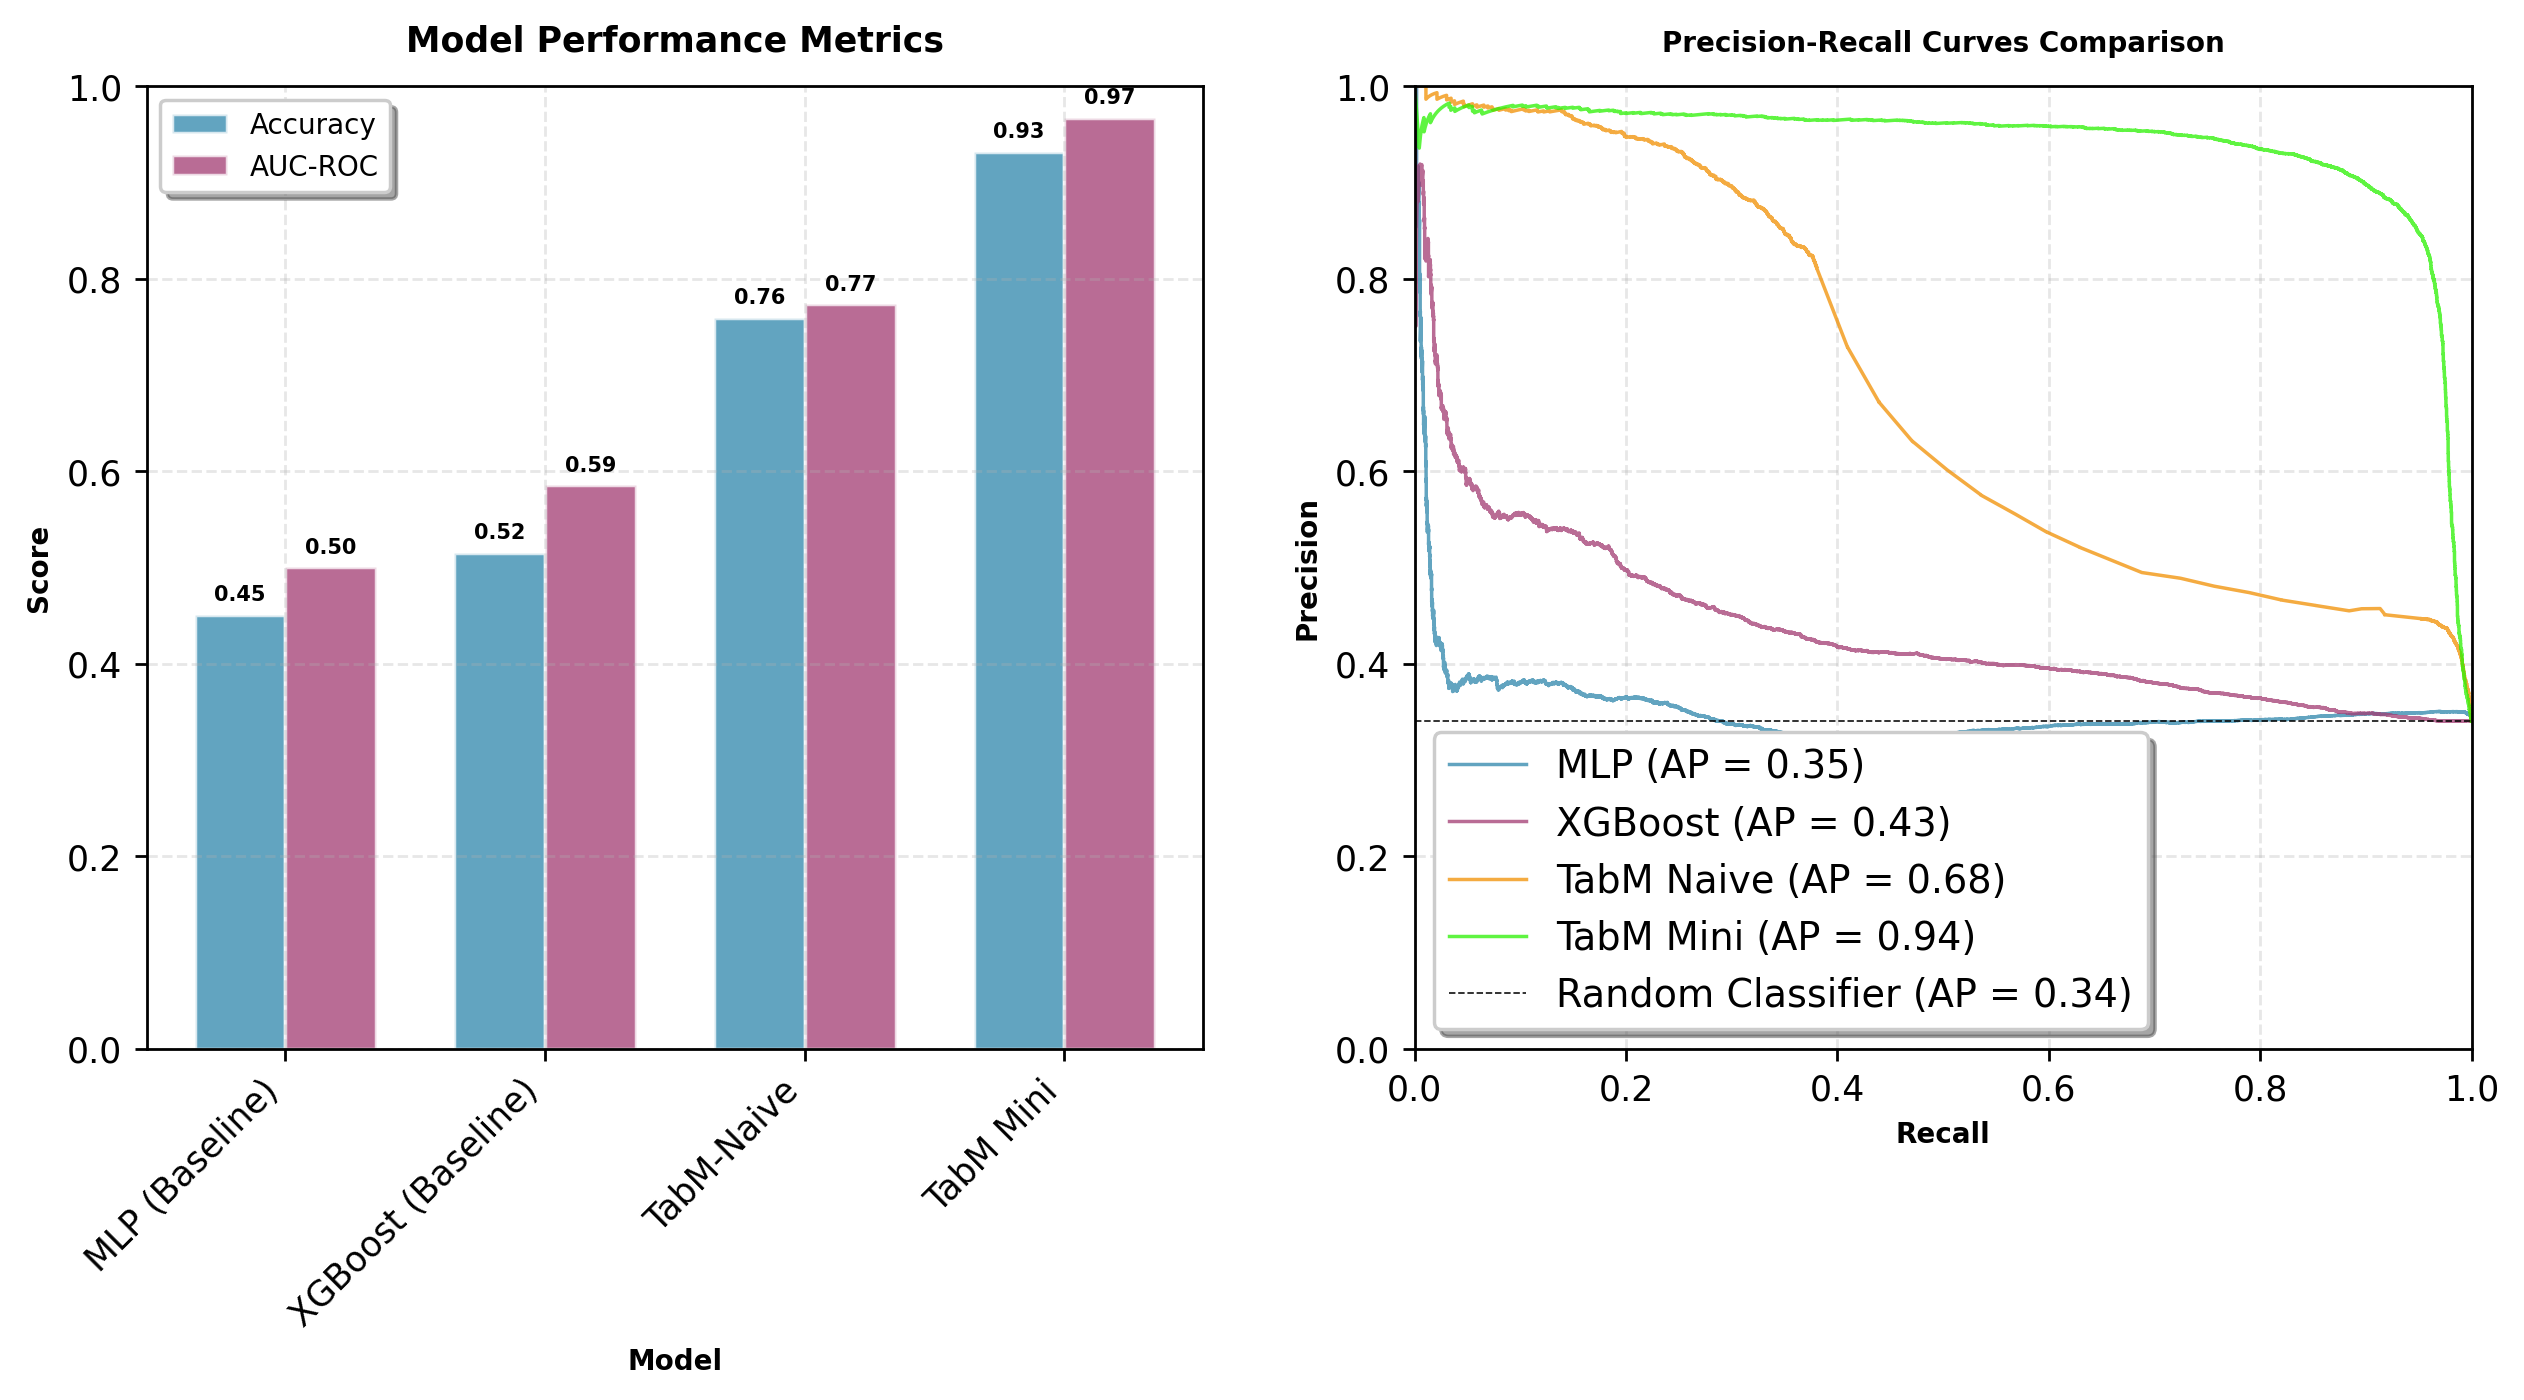

In [117]:
x = np.arange(len(all_models_comparison))

fig = plt.figure(figsize=(12, 5), dpi=250)

# Define consistent color palette
colors       = ['#2E86AB', '#A23B72', '#F18F01', '#29f101']
light_colors = ['#87CEEB', '#DDA0DD', '#FFD700', '#4966e6']

# 1. Performance metrics comparison with improved styling
ax1 = plt.subplot(1, 2, 1)

width = 0.35
bars1 = ax1.bar(x - width/2, all_models_comparison['Accuracy'], width, label='Accuracy', color=colors[0], alpha=0.75, edgecolor='white', linewidth=1)
bars2 = ax1.bar(x + width/2, all_models_comparison['AUC-ROC'], width, label='AUC-ROC', color=colors[1], alpha=0.75, edgecolor='white', linewidth=1)
ax1.set_ylim(0, 1)

ax1.set_xlabel('Model', fontsize=8, fontweight='bold')
ax1.set_ylabel('Score', fontsize=8, fontweight='bold')
ax1.set_title('Model Performance Metrics', fontsize=10, fontweight='bold', pad=10)
ax1.set_xticks(x)
ax1.set_xticklabels(all_models_comparison['Model'], rotation=45, ha='right', fontsize=10)
ax1.legend(fontsize=8, frameon=True, fancybox=True, shadow=True)
ax1.grid(True, alpha=0.3, linestyle='--')


# Add value labels on bars
for bar in bars1:
    height = bar.get_height()
    ax1.annotate(f'{height:.2f}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom', fontsize=6, fontweight='bold')

for bar in bars2:
    height = bar.get_height()
    ax1.annotate(f'{height:.2f}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom', fontsize=6, fontweight='bold')

# Create Precision-Recall curves for all models

ax2 = plt.subplot(1, 2, 2)

# MLP Precision-Recall curve
mlp_precision, mlp_recall, _ = precision_recall_curve(y_test, mlp_pred_proba)
mlp_ap = average_precision_score(y_test, mlp_pred_proba)

# XGBoost Precision-Recall curve
xgb_precision, xgb_recall, _ = precision_recall_curve(y_test, xgb_pred_proba)
xgb_ap = average_precision_score(y_test, xgb_pred_proba)

# TabM Naive Precision-Recall curve
tabm_naive_precision, tabm_naive_recall, _ = precision_recall_curve(y_test, tabm_naive_pred_proba)
tabm_naive_ap = average_precision_score(y_test, tabm_naive_pred_proba)

# TabM Mini Precision-Recall curve
tabm_mini_precision, tabm_mini_recall, _ = precision_recall_curve(y_test, tabm_mini_pred_proba)
tabm_mini_ap = average_precision_score(y_test, tabm_mini_pred_proba)

# Plot curves
ax2.plot(mlp_recall, mlp_precision, color=colors[0], linewidth=1, label=f'MLP (AP = {mlp_ap:.2f})', alpha=0.75)
ax2.plot(xgb_recall, xgb_precision, color=colors[1], linewidth=1, label=f'XGBoost (AP = {xgb_ap:.2f})', alpha=0.75)
ax2.plot(tabm_naive_recall, tabm_naive_precision, color=colors[2], linewidth=1, label=f'TabM Naive (AP = {tabm_naive_ap:.2f})', alpha=0.75)
ax2.plot(tabm_mini_recall, tabm_mini_precision, color=colors[3], linewidth=1, label=f'TabM Mini (AP = {tabm_mini_ap:.2f})', alpha=0.75)

# Add baseline (random classifier)
baseline_precision = y_test.mean()
ax2.axhline(y=baseline_precision, color='black', linestyle='--', alpha=0.9, linewidth=0.5, label=f'Random Classifier (AP = {baseline_precision:.2f})')

ax2.set_xlabel('Recall', fontsize=8, fontweight='bold')
ax2.set_ylabel('Precision', fontsize=8, fontweight='bold')
ax2.set_title('Precision-Recall Curves Comparison', fontsize=8, fontweight='bold', pad=10)
ax2.legend(fontsize=11, frameon=True, fancybox=True, shadow=True)
ax2.grid(True, alpha=0.3, linestyle='--')
ax2.set_xlim([0, 1])
ax2.set_ylim([0, 1])

##### Print additional statistics

In [119]:
print("\n" + "=" * 60)
print("Model Performance Summary:")
print("=" * 60)

for _, row in all_models_comparison.iterrows():
    print(f"\n{row['Model']}:")
    print(f"  - Accuracy: {row['Accuracy']:.4f}")
    print(f"  - AUC-ROC: {row['AUC-ROC']:.4f}")
    print(f"  - Type: {row['Model Type']}")
    
# Calculate relative improvements
baseline_acc = all_models_comparison.loc[all_models_comparison['Model'] == 'MLP (Baseline)', 'Accuracy'].values[0]
baseline_auc = all_models_comparison.loc[all_models_comparison['Model'] == 'MLP (Baseline)', 'AUC-ROC'].values[0]

print("\n" + "=" * 60)
print("Relative Performance vs MLP Baseline:")
print("=" * 60)

for _, row in all_models_comparison.iterrows():
    if row['Model'] != 'MLP (Baseline)':
        acc_improvement = ((row['Accuracy'] - baseline_acc) / baseline_acc) * 100
        auc_improvement = ((row['AUC-ROC'] - baseline_auc) / baseline_auc) * 100
        print(f"\n{row['Model']}:")
        print(f"  - Accuracy: {acc_improvement:+.2f}%")
        print(f"  - AUC-ROC: {auc_improvement:+.2f}%")


Model Performance Summary:

MLP (Baseline):
  - Accuracy: 0.4506
  - AUC-ROC: 0.4998
  - Type: Deep Learning

XGBoost (Baseline):
  - Accuracy: 0.5152
  - AUC-ROC: 0.5852
  - Type: Tree-based

TabM-Naive:
  - Accuracy: 0.7591
  - AUC-ROC: 0.7730
  - Type: TabM-Naive

TabM Mini:
  - Accuracy: 0.9315
  - AUC-ROC: 0.9669
  - Type: TabM-Mini

Relative Performance vs MLP Baseline:

XGBoost (Baseline):
  - Accuracy: +14.35%
  - AUC-ROC: +17.08%

TabM-Naive:
  - Accuracy: +68.45%
  - AUC-ROC: +54.66%

TabM Mini:
  - Accuracy: +106.71%
  - AUC-ROC: +93.46%
